In [1]:
!nvcc -V

/bin/bash: nvcc: command not found


In [2]:
pwd

'/home/nemesis/File'

In [3]:
!gcc --version

gcc (Ubuntu 9.3.0-17ubuntu1~20.04) 9.3.0
Copyright (C) 2019 Free Software Foundation, Inc.
This is free software; see the source for copying conditions.  There is NO
warranty; not even for MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.



In [1]:
import torch,torchvision
print(torch.version.__version__)
print(torch.cuda.is_available())

1.10.2
True


In [29]:
!pip install mmcv-full -f https://download.openmmlab.com/mmcv/dist/cu111/torch1.9.0/index.html

Looking in links: https://download.openmmlab.com/mmcv/dist/cu111/torch1.9.0/index.html
  Using cached https://download.openmmlab.com/mmcv/dist/cu111/torch1.9.0/mmcv_full-1.4.6-cp38-cp38-manylinux1_x86_64.whl (45.2 MB)


In [7]:
# Clone mmcls repository
!git clone https://github.com/open-mmlab/mmclassification.git
%cd mmclassification/

# Install MMClassification from source
!pip install -e . 

Obtaining file:///home/nemesis/File/mmclassification
  Preparing metadata (setup.py) ... done
  Attempting uninstall: mmcls
    Found existing installation: mmcls 0.21.0
    Uninstalling mmcls-0.21.0:
      Successfully uninstalled mmcls-0.21.0
  Running setup.py develop for mmcls


In [8]:
# Check MMClassification installation
import mmcls
print(mmcls.__version__)

0.21.0


# Using Pretrained models

In [83]:
# Get the demo image
# !wget https://www.dropbox.com/s/k5fsqi6qha09l1v/banana.png?dl=0 -O demo/banana.png

In [84]:
from PIL import Image
# Image.open('demo/cat-dog.png')

In [11]:
# Confirm the config file exists
!ls configs/mobilenet_v2/mobilenet-v2_8xb32_in1k.py

# Specify the path of the config file and checkpoint file.
config_file = 'configs/mobilenet_v2/mobilenet-v2_8xb32_in1k.py'
checkpoint_file = 'https://download.openmmlab.com/mmclassification/v0/mobilenet_v2/mobilenet_v2_batch256_imagenet_20200708-3b2dc3af.pth'

configs/mobilenet_v2/mobilenet-v2_8xb32_in1k.py


In [12]:
import mmcv
from mmcls.apis import inference_model, init_model, show_result_pyplot

# Specify the device, if you cannot use GPU, you can also use CPU 
# by specifying `device='cpu'`.
device = 'cuda:0'
# device = 'cpu'

# Build the model according to the config file and load the checkpoint.
model = init_model(config_file, checkpoint_file, device=device)

/home/nemesis/anaconda3/envs/open-mmlab/lib/python3.8/site-packages/mmcv/cnn/bricks/transformer.py:33: UserWarning: Fail to import ``MultiScaleDeformableAttention`` from ``mmcv.ops.multi_scale_deform_attn``, You should install ``mmcv-full`` if you need this module. 
  warnings.warn('Fail to import ``MultiScaleDeformableAttention`` from '


load checkpoint from http path: https://download.openmmlab.com/mmclassification/v0/mobilenet_v2/mobilenet_v2_batch256_imagenet_20200708-3b2dc3af.pth


/home/nemesis/File/mmclassification/mmcls/apis/inference.py:45: UserWarning: Class names are not saved in the checkpoint's meta data, use imagenet by default.
  warnings.warn('Class names are not saved in the checkpoint\'s '


In [13]:
# The model's inheritance relationship
model.__class__.__mro__

(mmcls.models.classifiers.image.ImageClassifier,
 mmcls.models.classifiers.base.BaseClassifier,
 mmcv.runner.base_module.BaseModule,
 torch.nn.modules.module.Module,
 object)

In [14]:
pwd

'/home/nemesis/File/mmclassification'

In [6]:
# cd /-

UsageError: %cd -: No previous directory to change to.


In [16]:
# The inference result in a single image
img = 'data/cat_dataset/train/Bengal/Bengal_2.jpg'
img_array =  mmcv.imread(img)
result = inference_model(model, img_array)
result

{'pred_label': 285,
 'pred_score': 0.7825708389282227,
 'pred_class': 'Egyptian cat'}

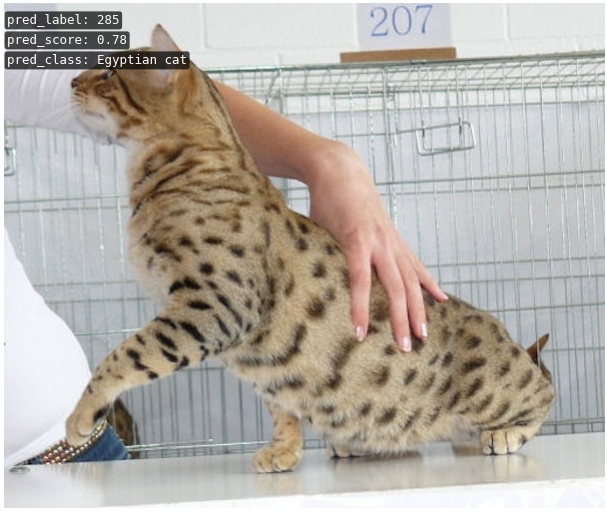

In [17]:
%matplotlib inline
# Visualize the inference result
show_result_pyplot(model, img, result)

###  Using pretrained model accuracy is not that good, Above image is a 'Bengal cat' but model has predicted it as Egyptian Cat
Next I Tried to tune the model and using custom dataset

## Fine-Tuning the model

In [18]:
pwd

'/home/nemesis/File'

In [19]:
# cd 'mmclassification/'

/home/nemesis/File/mmclassification


In [21]:
cd ./data/

/home/nemesis/File/mmclassification/data


In [56]:
"""
I downloaded the dataset and paste in below directory
/File/mmclassification/data

"""


'\nI downloaded the dataset and paste in below directory\n/File/mmclassification/data\n'

In [34]:
!tree -c -L 3

.
└── cat_dataset
    ├── train
    │   ├── Bengal
    │   ├── Ragdoll
    │   ├── Sphynx
    │   ├── British_Shorthair
    │   ├── Persian
    │   ├── Siamese
    │   ├── Maine_Coon
    │   ├── Russian_Blue
    │   ├── Abyssinian
    │   ├── Egyptian_Mau
    │   ├── Birman
    │   └── Bombay
    ├── val
    │   ├── Abyssinian
    │   ├── Bengal
    │   ├── Birman
    │   ├── British_Shorthair
    │   ├── Maine_Coon
    │   ├── Persian
    │   ├── Ragdoll
    │   ├── Russian_Blue
    │   ├── Siamese
    │   ├── Sphynx
    │   ├── Bombay
    │   └── Egyptian_Mau
    ├── classes.txt
    ├── test
    │   └── Bengal
    ├── test.txt
    └── val.txt

29 directories, 3 files


In [76]:
# Load the base config file
from mmcv import Config
cfg = Config.fromfile('configs/mobilenet_v2/mobilenet-v2_8xb32_in1k.py')

# Modify the number of classes in the head.
cfg.model.head.num_classes = 12
cfg.model.head.topk = (1, )

# Load the pre-trained model's checkpoint.
cfg.model.backbone.init_cfg = dict(type='Pretrained', checkpoint=checkpoint_file, prefix='backbone')

# Specify sample size and number of workers.
cfg.data.samples_per_gpu = 16
cfg.data.workers_per_gpu = 2

# Specify the path and meta files of training dataset
cfg.data.train.data_prefix = 'data/cat_dataset/train'
cfg.data.train.classes = 'data/cat_dataset/classes.txt'

# Specify the path and meta files of validation dataset
cfg.data.val.data_prefix = 'data/cat_dataset/val'
cfg.data.val.ann_file = 'data/cat_dataset/val.txt'
cfg.data.val.classes = 'data/cat_dataset/classes.txt'

# Specify the path and meta files of test dataset
cfg.data.test.data_prefix = 'data/cat_dataset/test'
cfg.data.test.ann_file = 'data/cat_dataset/test.txt'
cfg.data.test.classes = 'data/cat_dataset/classes.txt'

# Specify the normalization parameters in data pipeline
normalize_cfg = dict(type='Normalize', mean=[124.508, 116.050, 106.438], std=[58.577, 57.310, 57.437], to_rgb=True)
cfg.data.train.pipeline[3] = normalize_cfg
cfg.data.val.pipeline[3] = normalize_cfg
cfg.data.test.pipeline[3] = normalize_cfg

# Modify the evaluation metric
cfg.evaluation['metric_options']={'topk': (1, )}

# Specify the optimizer
cfg.optimizer = dict(type='SGD', lr=0.005, momentum=0.9, weight_decay=0.0001)
cfg.optimizer_config = dict(grad_clip=None)

# Specify the learning rate scheduler
cfg.lr_config = dict(policy='step', step=1, gamma=0.1)
cfg.runner = dict(type='EpochBasedRunner', max_epochs=10)

# Specify the work directory
cfg.work_dir = './work_dirs/cats_dataset'

# Output logs for every 5 iterations
cfg.log_config.interval = 5

# Set the random seed and enable the deterministic option of cuDNN
# to keep the results' reproducible.
from mmcls.apis import set_random_seed
cfg.seed = 0
set_random_seed(0, deterministic=True)

cfg.gpu_ids = range(1)

In [77]:
import time
import mmcv
import os.path as osp

from mmcls.datasets import build_dataset
from mmcls.models import build_classifier
from mmcls.apis import train_model

# Create the work directory
mmcv.mkdir_or_exist(osp.abspath(cfg.work_dir))
# Build the classifier
model = build_classifier(cfg.model)
model.init_weights()
# Build the dataset
datasets = [build_dataset(cfg.data.train)]
# Add `CLASSES` attributes to help visualization
model.CLASSES = datasets[0].CLASSES
# Start fine-tuning
train_model(
    model,
    datasets,
    cfg,
    distributed=False,
    validate=True,
    timestamp=time.strftime('%Y%m%d_%H%M%S', time.localtime()),
    meta=dict())

2022-03-09 15:19:11,450 - mmcv - INFO - initialize MobileNetV2 with init_cfg {'type': 'Pretrained', 'checkpoint': 'https://download.openmmlab.com/mmclassification/v0/mobilenet_v2/mobilenet_v2_batch256_imagenet_20200708-3b2dc3af.pth', 'prefix': 'backbone'}
2022-03-09 15:19:11,450 - mmcv - INFO - load backbone in model from: https://download.openmmlab.com/mmclassification/v0/mobilenet_v2/mobilenet_v2_batch256_imagenet_20200708-3b2dc3af.pth
2022-03-09 15:19:11,487 - mmcv - INFO - initialize LinearClsHead with init_cfg {'type': 'Normal', 'layer': 'Linear', 'std': 0.01}
2022-03-09 15:19:11,488 - mmcv - INFO - 
backbone.conv1.conv.weight - torch.Size([32, 3, 3, 3]): 
PretrainedInit: load from https://download.openmmlab.com/mmclassification/v0/mobilenet_v2/mobilenet_v2_batch256_imagenet_20200708-3b2dc3af.pth 
 
2022-03-09 15:19:11,489 - mmcv - INFO - 
backbone.conv1.bn.weight - torch.Size([32]): 
PretrainedInit: load from https://download.openmmlab.com/mmclassification/v0/mobilenet_v2/mobilen

2022-03-09 15:19:11,506 - mmcv - INFO - 
backbone.layer3.0.conv.1.bn.weight - torch.Size([144]): 
PretrainedInit: load from https://download.openmmlab.com/mmclassification/v0/mobilenet_v2/mobilenet_v2_batch256_imagenet_20200708-3b2dc3af.pth 
 
2022-03-09 15:19:11,506 - mmcv - INFO - 
backbone.layer3.0.conv.1.bn.bias - torch.Size([144]): 
PretrainedInit: load from https://download.openmmlab.com/mmclassification/v0/mobilenet_v2/mobilenet_v2_batch256_imagenet_20200708-3b2dc3af.pth 
 
2022-03-09 15:19:11,507 - mmcv - INFO - 
backbone.layer3.0.conv.2.conv.weight - torch.Size([32, 144, 1, 1]): 
PretrainedInit: load from https://download.openmmlab.com/mmclassification/v0/mobilenet_v2/mobilenet_v2_batch256_imagenet_20200708-3b2dc3af.pth 
 
2022-03-09 15:19:11,507 - mmcv - INFO - 
backbone.layer3.0.conv.2.bn.weight - torch.Size([32]): 
PretrainedInit: load from https://download.openmmlab.com/mmclassification/v0/mobilenet_v2/mobilenet_v2_batch256_imagenet_20200708-3b2dc3af.pth 
 
2022-03-09 15:1

2022-03-09 15:19:11,522 - mmcv - INFO - 
backbone.layer4.1.conv.0.bn.bias - torch.Size([384]): 
PretrainedInit: load from https://download.openmmlab.com/mmclassification/v0/mobilenet_v2/mobilenet_v2_batch256_imagenet_20200708-3b2dc3af.pth 
 
2022-03-09 15:19:11,523 - mmcv - INFO - 
backbone.layer4.1.conv.1.conv.weight - torch.Size([384, 1, 3, 3]): 
PretrainedInit: load from https://download.openmmlab.com/mmclassification/v0/mobilenet_v2/mobilenet_v2_batch256_imagenet_20200708-3b2dc3af.pth 
 
2022-03-09 15:19:11,523 - mmcv - INFO - 
backbone.layer4.1.conv.1.bn.weight - torch.Size([384]): 
PretrainedInit: load from https://download.openmmlab.com/mmclassification/v0/mobilenet_v2/mobilenet_v2_batch256_imagenet_20200708-3b2dc3af.pth 
 
2022-03-09 15:19:11,524 - mmcv - INFO - 
backbone.layer4.1.conv.1.bn.bias - torch.Size([384]): 
PretrainedInit: load from https://download.openmmlab.com/mmclassification/v0/mobilenet_v2/mobilenet_v2_batch256_imagenet_20200708-3b2dc3af.pth 
 
2022-03-09 15:19:

2022-03-09 15:19:11,535 - mmcv - INFO - 
backbone.layer5.1.conv.0.conv.weight - torch.Size([576, 96, 1, 1]): 
PretrainedInit: load from https://download.openmmlab.com/mmclassification/v0/mobilenet_v2/mobilenet_v2_batch256_imagenet_20200708-3b2dc3af.pth 
 
2022-03-09 15:19:11,535 - mmcv - INFO - 
backbone.layer5.1.conv.0.bn.weight - torch.Size([576]): 
PretrainedInit: load from https://download.openmmlab.com/mmclassification/v0/mobilenet_v2/mobilenet_v2_batch256_imagenet_20200708-3b2dc3af.pth 
 
2022-03-09 15:19:11,536 - mmcv - INFO - 
backbone.layer5.1.conv.0.bn.bias - torch.Size([576]): 
PretrainedInit: load from https://download.openmmlab.com/mmclassification/v0/mobilenet_v2/mobilenet_v2_batch256_imagenet_20200708-3b2dc3af.pth 
 
2022-03-09 15:19:11,536 - mmcv - INFO - 
backbone.layer5.1.conv.1.conv.weight - torch.Size([576, 1, 3, 3]): 
PretrainedInit: load from https://download.openmmlab.com/mmclassification/v0/mobilenet_v2/mobilenet_v2_batch256_imagenet_20200708-3b2dc3af.pth 
 
202

2022-03-09 15:19:11,557 - mmcv - INFO - 
backbone.layer6.1.conv.2.bn.weight - torch.Size([160]): 
PretrainedInit: load from https://download.openmmlab.com/mmclassification/v0/mobilenet_v2/mobilenet_v2_batch256_imagenet_20200708-3b2dc3af.pth 
 
2022-03-09 15:19:11,557 - mmcv - INFO - 
backbone.layer6.1.conv.2.bn.bias - torch.Size([160]): 
PretrainedInit: load from https://download.openmmlab.com/mmclassification/v0/mobilenet_v2/mobilenet_v2_batch256_imagenet_20200708-3b2dc3af.pth 
 
2022-03-09 15:19:11,558 - mmcv - INFO - 
backbone.layer6.2.conv.0.conv.weight - torch.Size([960, 160, 1, 1]): 
PretrainedInit: load from https://download.openmmlab.com/mmclassification/v0/mobilenet_v2/mobilenet_v2_batch256_imagenet_20200708-3b2dc3af.pth 
 
2022-03-09 15:19:11,559 - mmcv - INFO - 
backbone.layer6.2.conv.0.bn.weight - torch.Size([960]): 
PretrainedInit: load from https://download.openmmlab.com/mmclassification/v0/mobilenet_v2/mobilenet_v2_batch256_imagenet_20200708-3b2dc3af.pth 
 
2022-03-09 15

load checkpoint from http path: https://download.openmmlab.com/mmclassification/v0/mobilenet_v2/mobilenet_v2_batch256_imagenet_20200708-3b2dc3af.pth


2022-03-09 15:19:14,659 - mmcls - INFO - Epoch [1][5/105]	lr: 5.000e-03, eta: 0:10:19, time: 0.592, data_time: 0.439, memory: 1380, loss: 2.4920
2022-03-09 15:19:15,590 - mmcls - INFO - Epoch [1][10/105]	lr: 5.000e-03, eta: 0:06:45, time: 0.186, data_time: 0.018, memory: 1380, loss: 2.3792
2022-03-09 15:19:16,426 - mmcls - INFO - Epoch [1][15/105]	lr: 5.000e-03, eta: 0:05:26, time: 0.167, data_time: 0.018, memory: 1380, loss: 2.0468
2022-03-09 15:19:17,260 - mmcls - INFO - Epoch [1][20/105]	lr: 5.000e-03, eta: 0:04:46, time: 0.165, data_time: 0.017, memory: 1380, loss: 1.6747
2022-03-09 15:19:18,098 - mmcls - INFO - Epoch [1][25/105]	lr: 5.000e-03, eta: 0:04:22, time: 0.167, data_time: 0.019, memory: 1380, loss: 1.4980
2022-03-09 15:19:18,941 - mmcls - INFO - Epoch [1][30/105]	lr: 5.000e-03, eta: 0:04:06, time: 0.169, data_time: 0.019, memory: 1380, loss: 1.4344
2022-03-09 15:19:19,777 - mmcls - INFO - Epoch [1][35/105]	lr: 5.000e-03, eta: 0:03:54, time: 0.167, data_time: 0.019, memory

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 715/715, 45.8 task/s, elapsed: 16s, ETA:     0s

2022-03-09 15:19:47,642 - mmcls - INFO - Epoch(val) [1][45]	accuracy_top-1: 40.1399
2022-03-09 15:19:50,653 - mmcls - INFO - Epoch [2][5/105]	lr: 5.000e-04, eta: 0:03:17, time: 0.579, data_time: 0.427, memory: 1380, loss: 1.6367
2022-03-09 15:19:51,803 - mmcls - INFO - Epoch [2][10/105]	lr: 5.000e-04, eta: 0:03:17, time: 0.233, data_time: 0.016, memory: 1380, loss: 1.4456
2022-03-09 15:19:55,087 - mmcls - INFO - Epoch [2][15/105]	lr: 5.000e-04, eta: 0:03:33, time: 0.668, data_time: 0.198, memory: 1380, loss: 1.5013
2022-03-09 15:19:58,103 - mmcls - INFO - Epoch [2][20/105]	lr: 5.000e-04, eta: 0:03:46, time: 0.595, data_time: 0.210, memory: 1380, loss: 1.1009
2022-03-09 15:19:59,452 - mmcls - INFO - Epoch [2][25/105]	lr: 5.000e-04, eta: 0:03:46, time: 0.274, data_time: 0.083, memory: 1380, loss: 1.0819
2022-03-09 15:20:02,893 - mmcls - INFO - Epoch [2][30/105]	lr: 5.000e-04, eta: 0:03:59, time: 0.691, data_time: 0.231, memory: 1380, loss: 0.8665
2022-03-09 15:20:07,034 - mmcls - INFO - 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 715/715, 16.4 task/s, elapsed: 44s, ETA:     0s

2022-03-09 15:21:56,818 - mmcls - INFO - Epoch(val) [2][45]	accuracy_top-1: 78.4615
2022-03-09 15:22:01,220 - mmcls - INFO - Epoch [3][5/105]	lr: 5.000e-05, eta: 0:07:02, time: 0.867, data_time: 0.654, memory: 1380, loss: 0.8074
2022-03-09 15:22:04,191 - mmcls - INFO - Epoch [3][10/105]	lr: 5.000e-05, eta: 0:07:02, time: 0.599, data_time: 0.206, memory: 1380, loss: 0.7242
2022-03-09 15:22:09,879 - mmcls - INFO - Epoch [3][15/105]	lr: 5.000e-05, eta: 0:07:11, time: 1.138, data_time: 0.487, memory: 1380, loss: 0.6278
2022-03-09 15:22:14,458 - mmcls - INFO - Epoch [3][20/105]	lr: 5.000e-05, eta: 0:07:15, time: 0.916, data_time: 0.278, memory: 1380, loss: 0.5538
2022-03-09 15:22:20,514 - mmcls - INFO - Epoch [3][25/105]	lr: 5.000e-05, eta: 0:07:24, time: 1.211, data_time: 0.479, memory: 1380, loss: 0.5679
2022-03-09 15:22:24,989 - mmcls - INFO - Epoch [3][30/105]	lr: 5.000e-05, eta: 0:07:27, time: 0.895, data_time: 0.246, memory: 1380, loss: 0.7095
2022-03-09 15:22:30,122 - mmcls - INFO - 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 715/715, 16.1 task/s, elapsed: 45s, ETA:     0s

2022-03-09 15:24:30,905 - mmcls - INFO - Epoch(val) [3][45]	accuracy_top-1: 79.4406
2022-03-09 15:24:40,178 - mmcls - INFO - Epoch [4][5/105]	lr: 5.000e-06, eta: 0:08:26, time: 1.847, data_time: 1.229, memory: 1380, loss: 0.7057
2022-03-09 15:24:44,943 - mmcls - INFO - Epoch [4][10/105]	lr: 5.000e-06, eta: 0:08:26, time: 0.953, data_time: 0.320, memory: 1380, loss: 0.6066
2022-03-09 15:24:50,377 - mmcls - INFO - Epoch [4][15/105]	lr: 5.000e-06, eta: 0:08:27, time: 1.087, data_time: 0.468, memory: 1380, loss: 0.5548
2022-03-09 15:24:55,185 - mmcls - INFO - Epoch [4][20/105]	lr: 5.000e-06, eta: 0:08:26, time: 0.961, data_time: 0.329, memory: 1380, loss: 0.4771
2022-03-09 15:25:00,882 - mmcls - INFO - Epoch [4][25/105]	lr: 5.000e-06, eta: 0:08:27, time: 1.140, data_time: 0.529, memory: 1380, loss: 0.7257
2022-03-09 15:25:05,793 - mmcls - INFO - Epoch [4][30/105]	lr: 5.000e-06, eta: 0:08:26, time: 0.982, data_time: 0.349, memory: 1380, loss: 0.6774
2022-03-09 15:25:11,142 - mmcls - INFO - 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 715/715, 16.0 task/s, elapsed: 45s, ETA:     0s

2022-03-09 15:27:09,990 - mmcls - INFO - Epoch(val) [4][45]	accuracy_top-1: 79.4406
2022-03-09 15:27:18,777 - mmcls - INFO - Epoch [5][5/105]	lr: 5.000e-07, eta: 0:08:12, time: 1.749, data_time: 1.127, memory: 1380, loss: 0.7765
2022-03-09 15:27:23,536 - mmcls - INFO - Epoch [5][10/105]	lr: 5.000e-07, eta: 0:08:09, time: 0.952, data_time: 0.298, memory: 1380, loss: 0.6891
2022-03-09 15:27:29,019 - mmcls - INFO - Epoch [5][15/105]	lr: 5.000e-07, eta: 0:08:08, time: 1.096, data_time: 0.460, memory: 1380, loss: 0.7021
2022-03-09 15:27:34,350 - mmcls - INFO - Epoch [5][20/105]	lr: 5.000e-07, eta: 0:08:06, time: 1.065, data_time: 0.382, memory: 1380, loss: 0.5783
2022-03-09 15:27:40,790 - mmcls - INFO - Epoch [5][25/105]	lr: 5.000e-07, eta: 0:08:05, time: 1.289, data_time: 0.668, memory: 1380, loss: 0.5321
2022-03-09 15:27:45,900 - mmcls - INFO - Epoch [5][30/105]	lr: 5.000e-07, eta: 0:08:02, time: 1.022, data_time: 0.392, memory: 1380, loss: 0.4294
2022-03-09 15:27:52,051 - mmcls - INFO - 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 715/715, 16.1 task/s, elapsed: 44s, ETA:     0s

2022-03-09 15:29:48,631 - mmcls - INFO - Epoch(val) [5][45]	accuracy_top-1: 80.0000
2022-03-09 15:29:57,175 - mmcls - INFO - Epoch [6][5/105]	lr: 5.000e-08, eta: 0:07:19, time: 1.701, data_time: 1.106, memory: 1380, loss: 0.5447
2022-03-09 15:30:01,561 - mmcls - INFO - Epoch [6][10/105]	lr: 5.000e-08, eta: 0:07:15, time: 0.877, data_time: 0.268, memory: 1380, loss: 0.8601
2022-03-09 15:30:07,044 - mmcls - INFO - Epoch [6][15/105]	lr: 5.000e-08, eta: 0:07:12, time: 1.097, data_time: 0.492, memory: 1380, loss: 0.7423
2022-03-09 15:30:11,944 - mmcls - INFO - Epoch [6][20/105]	lr: 5.000e-08, eta: 0:07:08, time: 0.980, data_time: 0.327, memory: 1380, loss: 0.6283
2022-03-09 15:30:17,923 - mmcls - INFO - Epoch [6][25/105]	lr: 5.000e-08, eta: 0:07:06, time: 1.195, data_time: 0.543, memory: 1380, loss: 0.7064
2022-03-09 15:30:22,939 - mmcls - INFO - Epoch [6][30/105]	lr: 5.000e-08, eta: 0:07:02, time: 1.003, data_time: 0.284, memory: 1380, loss: 1.1040
2022-03-09 15:30:30,863 - mmcls - INFO - 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 715/715, 16.0 task/s, elapsed: 45s, ETA:     0s

2022-03-09 15:32:29,337 - mmcls - INFO - Epoch(val) [6][45]	accuracy_top-1: 78.7413
2022-03-09 15:32:38,611 - mmcls - INFO - Epoch [7][5/105]	lr: 5.000e-09, eta: 0:06:08, time: 1.847, data_time: 1.183, memory: 1380, loss: 0.5618
2022-03-09 15:32:43,566 - mmcls - INFO - Epoch [7][10/105]	lr: 5.000e-09, eta: 0:06:04, time: 0.991, data_time: 0.364, memory: 1380, loss: 0.6980
2022-03-09 15:32:48,932 - mmcls - INFO - Epoch [7][15/105]	lr: 5.000e-09, eta: 0:06:00, time: 1.073, data_time: 0.416, memory: 1380, loss: 0.7707
2022-03-09 15:32:53,522 - mmcls - INFO - Epoch [7][20/105]	lr: 5.000e-09, eta: 0:05:56, time: 0.918, data_time: 0.302, memory: 1380, loss: 0.8354
2022-03-09 15:32:58,604 - mmcls - INFO - Epoch [7][25/105]	lr: 5.000e-09, eta: 0:05:52, time: 1.016, data_time: 0.363, memory: 1380, loss: 0.7233
2022-03-09 15:33:03,671 - mmcls - INFO - Epoch [7][30/105]	lr: 5.000e-09, eta: 0:05:48, time: 1.013, data_time: 0.381, memory: 1380, loss: 0.6150
2022-03-09 15:33:08,096 - mmcls - INFO - 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 715/715, 15.8 task/s, elapsed: 45s, ETA:     0s

2022-03-09 15:36:00,525 - mmcls - INFO - Epoch(val) [7][45]	accuracy_top-1: 78.8811
2022-03-09 15:36:10,791 - mmcls - INFO - Epoch [8][5/105]	lr: 5.000e-10, eta: 0:04:44, time: 2.045, data_time: 1.413, memory: 1380, loss: 0.6534
2022-03-09 15:36:15,083 - mmcls - INFO - Epoch [8][10/105]	lr: 5.000e-10, eta: 0:04:39, time: 0.858, data_time: 0.199, memory: 1380, loss: 0.7152
2022-03-09 15:36:20,861 - mmcls - INFO - Epoch [8][15/105]	lr: 5.000e-10, eta: 0:04:35, time: 1.156, data_time: 0.517, memory: 1380, loss: 0.7092
2022-03-09 15:36:25,341 - mmcls - INFO - Epoch [8][20/105]	lr: 5.000e-10, eta: 0:04:30, time: 0.896, data_time: 0.287, memory: 1380, loss: 1.0103
2022-03-09 15:36:30,305 - mmcls - INFO - Epoch [8][25/105]	lr: 5.000e-10, eta: 0:04:26, time: 0.993, data_time: 0.375, memory: 1380, loss: 0.6823
2022-03-09 15:36:34,885 - mmcls - INFO - Epoch [8][30/105]	lr: 5.000e-10, eta: 0:04:21, time: 0.916, data_time: 0.283, memory: 1380, loss: 0.6797
2022-03-09 15:36:39,943 - mmcls - INFO - 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 715/715, 15.9 task/s, elapsed: 45s, ETA:     0s

2022-03-09 15:38:38,640 - mmcls - INFO - Epoch(val) [8][45]	accuracy_top-1: 78.8811
2022-03-09 15:38:47,521 - mmcls - INFO - Epoch [9][5/105]	lr: 5.000e-11, eta: 0:03:11, time: 1.768, data_time: 1.132, memory: 1380, loss: 0.6729
2022-03-09 15:38:52,542 - mmcls - INFO - Epoch [9][10/105]	lr: 5.000e-11, eta: 0:03:06, time: 1.004, data_time: 0.339, memory: 1380, loss: 0.5882
2022-03-09 15:38:58,027 - mmcls - INFO - Epoch [9][15/105]	lr: 5.000e-11, eta: 0:03:02, time: 1.097, data_time: 0.427, memory: 1380, loss: 0.8785
2022-03-09 15:39:02,646 - mmcls - INFO - Epoch [9][20/105]	lr: 5.000e-11, eta: 0:02:57, time: 0.924, data_time: 0.295, memory: 1380, loss: 0.7120
2022-03-09 15:39:07,730 - mmcls - INFO - Epoch [9][25/105]	lr: 5.000e-11, eta: 0:02:53, time: 1.016, data_time: 0.397, memory: 1380, loss: 0.7044
2022-03-09 15:39:12,633 - mmcls - INFO - Epoch [9][30/105]	lr: 5.000e-11, eta: 0:02:48, time: 0.981, data_time: 0.352, memory: 1380, loss: 0.6536
2022-03-09 15:39:18,700 - mmcls - INFO - 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 715/715, 16.1 task/s, elapsed: 44s, ETA:     0s

2022-03-09 15:41:16,902 - mmcls - INFO - Epoch(val) [9][45]	accuracy_top-1: 78.7413
2022-03-09 15:41:25,590 - mmcls - INFO - Epoch [10][5/105]	lr: 5.000e-12, eta: 0:01:34, time: 1.730, data_time: 1.092, memory: 1380, loss: 0.6714
2022-03-09 15:41:31,117 - mmcls - INFO - Epoch [10][10/105]	lr: 5.000e-12, eta: 0:01:30, time: 1.105, data_time: 0.446, memory: 1380, loss: 0.7720
2022-03-09 15:41:37,377 - mmcls - INFO - Epoch [10][15/105]	lr: 5.000e-12, eta: 0:01:25, time: 1.252, data_time: 0.563, memory: 1380, loss: 0.7828
2022-03-09 15:41:43,280 - mmcls - INFO - Epoch [10][20/105]	lr: 5.000e-12, eta: 0:01:20, time: 1.180, data_time: 0.492, memory: 1380, loss: 0.8147
2022-03-09 15:41:48,747 - mmcls - INFO - Epoch [10][25/105]	lr: 5.000e-12, eta: 0:01:16, time: 1.093, data_time: 0.438, memory: 1380, loss: 0.9421
2022-03-09 15:41:53,280 - mmcls - INFO - Epoch [10][30/105]	lr: 5.000e-12, eta: 0:01:11, time: 0.907, data_time: 0.268, memory: 1380, loss: 0.7384
2022-03-09 15:41:58,777 - mmcls - I

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 715/715, 15.9 task/s, elapsed: 45s, ETA:     0s

2022-03-09 15:43:57,176 - mmcls - INFO - Epoch(val) [10][45]	accuracy_top-1: 79.3007


### After Fine-Tuning we get an zccuracy of about 79 percent in epochs=10 which is pretty good. 
Next lets do prediction

## Prediction

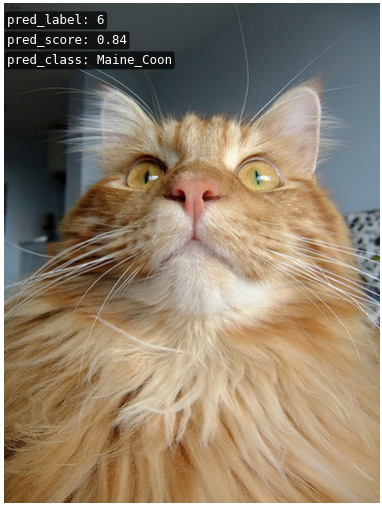

In [82]:
%matplotlib inline
# Validate the fine-tuned model

img = mmcv.imread('data/cat_dataset/val/Maine_Coon/Maine_Coon_173.jpg')

model.cfg = cfg
result = inference_model(model, img)

show_result_pyplot(model, img, result)

In [28]:
# import os
# directory = r"data/cat_dataset/train/"
# categories = ['Abyssinian','Bengal','Birman','Bombay','British_Shorthair','Egyptian_Mau','Maine_Coon','Persian','Ragdoll','Russian_Blue','Siamese','Sphynx']

# img_file = []
# for category in categories:
    
#     folder = os.path.join(directory,category)
#     label = categories.index(category)
#     print(f"category {category}",end="")
#     for img in os.listdir(folder):
#         #img_path = os.path.join(folder,img)
#         img_path = str(category) +"/"+str(img)+" "+ str(label)
#         img_file.append(img_path)
        
#     print("\tDone $")

category Abyssinian	Done $
category Bengal	Done $
category Birman	Done $
category Bombay	Done $
category British_Shorthair	Done $
category Egyptian_Mau	Done $
category Maine_Coon	Done $
category Persian	Done $
category Ragdoll	Done $
category Russian_Blue	Done $
category Siamese	Done $
category Sphynx	Done $


In [106]:
# pip freeze